# Preprocessing of the Hypothyroid dataset

In this notebook we describe the different preprocessing steps we realize on the Hypothyroid dataset to prepare it for the clustering algorithms.

In [52]:
# Imports
import pandas as pd
from scipy.io.arff import loadarff
import os
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

# Useful methods
def load_arff(dataset_name: str):
    f = open(os.path.abspath(os.path.join('..', 'datasets', 'all', dataset_name + '.arff')))
    data, metadata = loadarff(f)
    return data, metadata

def plot_hist(array, title):
    plt.figure(figsize=(10,5))
    plt.hist(array, bins=50, facecolor='b')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.title(title)
    plt.show()
    
def min_max_normalize(array):
   max_value = np.max(array)
   min_value = np.min(array)
   output = np.zeros(array.shape)
   if max_value != min_value:
     output = (array - min_value)/(max_value - min_value)
   return output

## Introduction

We first load the dataset and do a quick check to the data

In [2]:
# Load dataset
data, metadata = load_arff('hypothyroid')
data = pd.DataFrame(data)
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',125.0,b't',1.14,b't',109.0,b'f',NaN,b'SVHC',b'negative'
1,23.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',102.0,b'f',NaN,b'f',NaN,b'f',NaN,b'other',b'negative'
2,46.0,b'M',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',109.0,b't',0.91,b't',120.0,b'f',NaN,b'other',b'negative'
3,70.0,b'F',b't',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',175.0,b'f',NaN,b'f',NaN,b'f',NaN,b'other',b'negative'
4,70.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',61.0,b't',0.87,b't',70.0,b'f',NaN,b'SVI',b'negative'


In [3]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Columns: 30 entries, age to Class
dtypes: float64(7), object(23)
memory usage: 884.2+ KB


In [4]:
print(metadata)

Dataset: hypothyroid
	age's type is numeric
	sex's type is nominal, range is ('F', 'M')
	on_thyroxine's type is nominal, range is ('f', 't')
	query_on_thyroxine's type is nominal, range is ('f', 't')
	on_antithyroid_medication's type is nominal, range is ('f', 't')
	sick's type is nominal, range is ('f', 't')
	pregnant's type is nominal, range is ('f', 't')
	thyroid_surgery's type is nominal, range is ('f', 't')
	I131_treatment's type is nominal, range is ('f', 't')
	query_hypothyroid's type is nominal, range is ('f', 't')
	query_hyperthyroid's type is nominal, range is ('f', 't')
	lithium's type is nominal, range is ('f', 't')
	goitre's type is nominal, range is ('f', 't')
	tumor's type is nominal, range is ('f', 't')
	hypopituitary's type is nominal, range is ('f', 't')
	psych's type is nominal, range is ('f', 't')
	TSH_measured's type is nominal, range is ('t', 'f')
	TSH's type is numeric
	T3_measured's type is nominal, range is ('t', 'f')
	T3's type is numeric
	TT4_measured's type 

In [5]:
# for later operations
data_numeric = data[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']]
data_nominal = data[data.columns.difference(['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG', 'Class'])]
data_class = data['Class']

In [57]:
data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'referral_source', 'Class'],
      dtype='object')

For summarizing, the dataset has the following characteristics:
- It hast a total of 3772 samples and 29 features (we don't count the class column)
- It has 7 numerical features and 22 nominal features (we don't count the class column).
- 20 of the nominal features have only 2 different values.
- The feature to predict is nominal and has 4 different values.

## Preprocessing

Firslty we check the total number of NaNs and the number of NaNs per row.

In [6]:
count_nans = data.isnull().sum().sum()
print('Total number: ', count_nans, '; relative: ', (count_nans*100)/(len(data.index)*len(data.columns)), '%')

Total number:  5914 ; relative:  5.226228349240015 %


In [7]:
nans_per_row = data.isnull().sum(axis=1).tolist()
unique, counts = np.unique(np.asarray(nans_per_row), return_counts=True)
x = PrettyTable()
x.field_names = ['Number of NaNs in the row', 'Number of rows']
for index, value in enumerate(unique):
    x.add_row([value, counts[index]])
print(x)

+---------------------------+----------------+
| Number of NaNs in the row | Number of rows |
+---------------------------+----------------+
|             1             |      2751      |
|             2             |      538       |
|             3             |      247       |
|             4             |       13       |
|             5             |       44       |
|             6             |      179       |
+---------------------------+----------------+


We can see that the majority of rows have between 1 and 3 NaNs. It is necessary to process these NaNs. The rows with more NaNs have 6 columns without a defined value that is still a razonable number compared to the total number of columns (30).

Secondly we preprocess each column separately, first the numerical features, secondly the nominal features and lastly the class column. For summarizing we do the following preprocessing steps:
- Replace the NaN values of each numerical feature by the mean.
- Replace the NaN values of each nominal feature by the median.
- Replace the outliers of each numerical feature by the closest value.
- Normalize all the numerical features.

### Check the numerical features

For each feature we process the NaN values and replace the outliers if necessary. At the end we also normalize all the features.

#### Age

In [8]:
column = data['age']

NaNs checking

In [9]:
column.isnull().sum()

1

Outliers checking

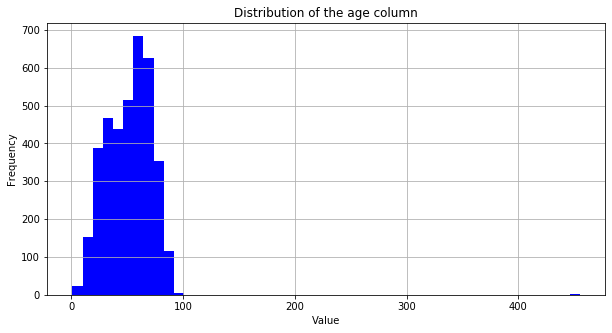

In [10]:
plot_hist(column[column.notna()], 'Distribution of the age column')

We have a NaN value and an outlier. We replace the outlier by the maximum value apart from him and replace the NaN value by the mean.

In [11]:
outliers_list = data.index[column > 400].tolist()
nans_list = data.index[column.isnull()].tolist()

In [12]:
column = column.to_numpy()
column_clean = np.delete(column, nans_list + outliers_list)
mean_clean = np.mean(column_clean)
max_clean = np.max(column_clean)
column[nans_list] = mean_clean
column[outliers_list] = max_clean

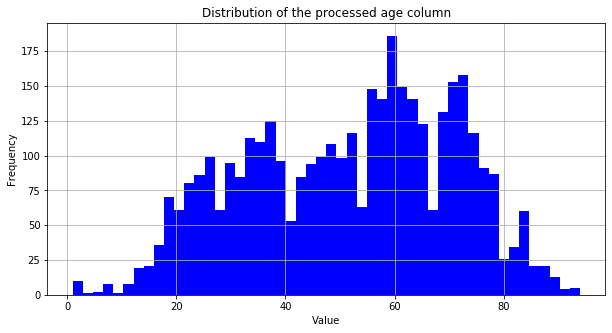

In [13]:
data['age'] = column
plot_hist(data['age'], 'Distribution of the processed age column')

#### TSH

In [14]:
column = data['TSH']

NaNs checking

In [15]:
column.isnull().sum()

369

Outliers checking

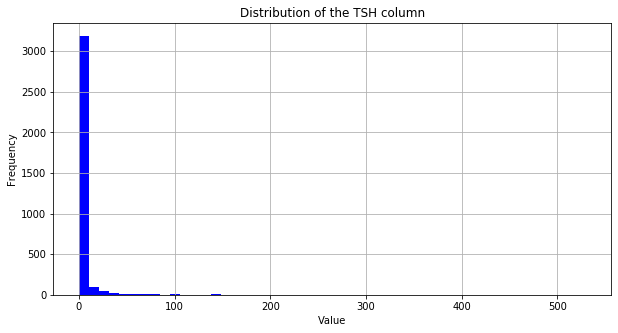

In [16]:
plot_hist(column[column.notna()], 'Distribution of the TSH column')

We have 369 NaN values and two outliers. We replace the outliers by the maximum value apart from them and replace the NaN values by the mean.

In [17]:
outliers_list = data.index[column > 80].tolist()
nans_list = data.index[column.isnull()].tolist()

In [18]:
column = column.to_numpy()
column_clean = np.delete(column, nans_list + outliers_list)
mean_clean = np.mean(column_clean)
max_clean = np.max(column_clean)
column[nans_list] = mean_clean
column[outliers_list] = max_clean

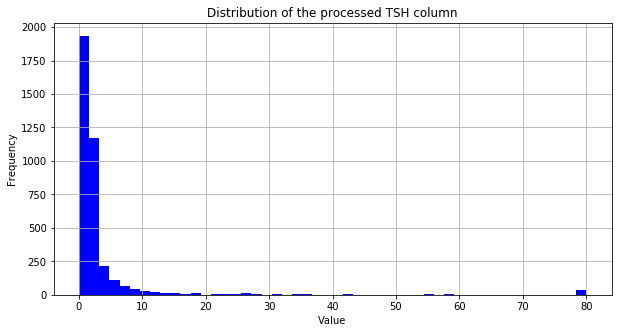

In [19]:
data['TSH'] = column
plot_hist(data['TSH'], 'Distribution of the processed TSH column')

#### T3

In [22]:
column = data['T3']

NaNs checking

In [23]:
column.isnull().sum()

769

Outliers checking

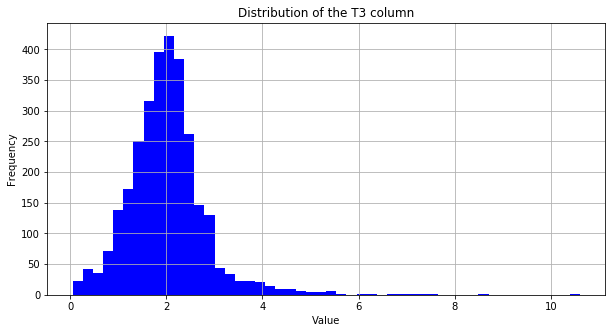

In [24]:
plot_hist(column[column.notna()], 'Distribution of the T3 column')

We have 769 NaN values and one outlier. We replace the outlier by the maximum value apart from him and replace the NaN values by the mean.

In [25]:
outliers_list = data.index[column > 10].tolist()
nans_list = data.index[column.isnull()].tolist()

In [26]:
column = column.to_numpy()
column_clean = np.delete(column, nans_list + outliers_list)
mean_clean = np.mean(column_clean)
max_clean = np.max(column_clean)
column[nans_list] = mean_clean
column[outliers_list] = max_clean

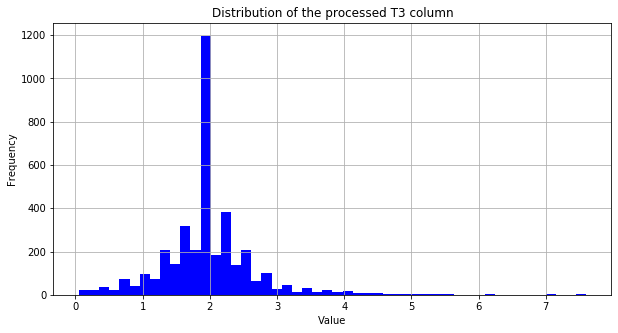

In [27]:
data['T3'] = column
plot_hist(data['T3'], 'Distribution of the processed T3 column')

#### TT4

In [28]:
column = data['TT4']

NaNs checking

In [29]:
column.isnull().sum()

231

Outliers checking

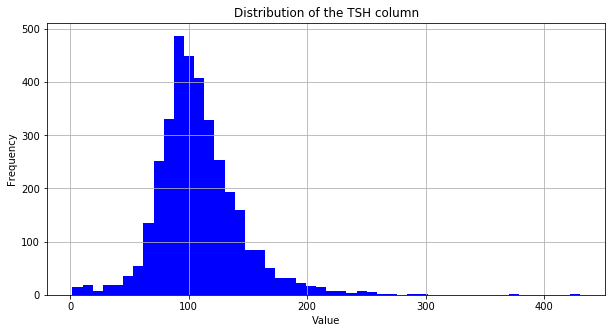

In [30]:
plot_hist(column[column.notna()], 'Distribution of the TT4 column')

We have 231 NaN values and two outliers. We replace the outliers by the maximum value apart from them and replace the NaN values by the mean.

In [31]:
outliers_list = data.index[column > 350].tolist()
nans_list = data.index[column.isnull()].tolist()

In [32]:
column = column.to_numpy()
column_clean = np.delete(column, nans_list + outliers_list)
mean_clean = np.mean(column_clean)
max_clean = np.max(column_clean)
column[nans_list] = mean_clean
column[outliers_list] = max_clean

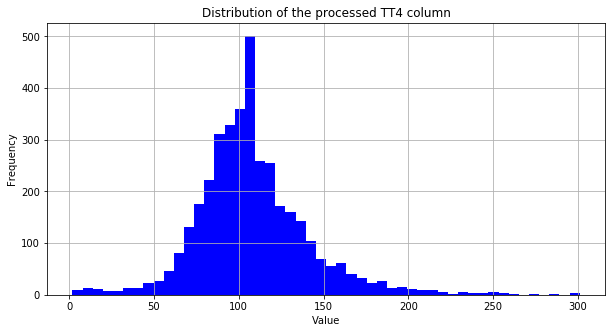

In [34]:
data['TT4'] = column
plot_hist(data['TT4'], 'Distribution of the processed TT4 column')

#### T4U

In [35]:
column = data['T4U']

NaNs checking

In [36]:
column.isnull().sum()

387

Outliers checking

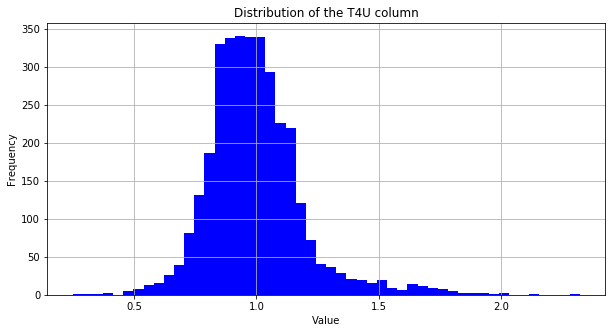

In [37]:
plot_hist(column[column.notna()], 'Distribution of the T4U column')

We have 387 NaN values. We replace the NaN values by the mean.

In [38]:
nans_list = data.index[column.isnull()].tolist()

In [45]:
column = column.to_numpy()
column_clean = np.delete(column, nans_list)
mean_clean = np.mean(column_clean)
max_clean = np.max(column_clean)
column[nans_list] = mean_clean
column[outliers_list] = max_clean

#### FTI

In [41]:
column = data['FTI']

NaNs checking

In [42]:
column.isnull().sum()

385

Outliers checking

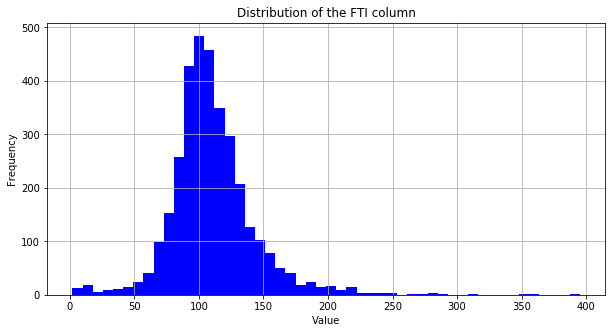

In [43]:
plot_hist(column[column.notna()], 'Distribution of the FTI column')

We have 385 NaN values. We replace the NaN values by the mean.

In [44]:
nans_list = data.index[column.isnull()].tolist()

In [46]:
column = column.to_numpy()
column_clean = np.delete(column, nans_list)
mean_clean = np.mean(column_clean)
max_clean = np.max(column_clean)
column[nans_list] = mean_clean
column[outliers_list] = max_clean

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

#### TBG

In [47]:
column = data['TBG']

NaNs checking

In [48]:
column.isnull().sum()

3772

All the values of this column are NaN, so we delete this column

In [49]:
del data['TBG']

#### Normalization

Now we normalize all the numerical columns using min-max normalization

In [54]:
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
for column_index in numeric_columns:
    normalized_column = min_max_normalize(data[column_index].to_numpy())
    data[column_index] = normalized_column

### Check nominal features

We replace the NaN values of each nominal feature by the median

### Check the class feature

In this subsection we analyse the feature to predict. 

We check the number of samples for each possible class (in absolute and relative value).

In [20]:
print(data['Class'].value_counts(), '\n')
print(data['Class'].value_counts(normalize=True))

b'negative'                   3481
b'compensated_hypothyroid'     194
b'primary_hypothyroid'          95
b'secondary_hypothyroid'         2
Name: Class, dtype: int64 

b'negative'                   0.922853
b'compensated_hypothyroid'    0.051432
b'primary_hypothyroid'        0.025186
b'secondary_hypothyroid'      0.000530
Name: Class, dtype: float64


We can clearly see that the dataset is highly descompensated, the 92,29% of the samples belong to only one class..

Now we check the correlation with the numeric features

In [21]:
corr = data_numeric.corr()
corr.style.background_gradient(cmap='coolwarm')

/home/ferran/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/ferran/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/home/ferran/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,age,TSH,T3,TT4,T4U,FTI,TBG
age,1.000000,-0.059087,-0.238412,-0.038841,-0.166250,0.052788,nan
TSH,-0.059087,1.000000,-0.161823,-0.267365,0.073391,-0.304684,nan
T3,-0.238412,-0.161823,1.000000,0.559503,0.454127,0.348921,nan
TT4,-0.038841,-0.267365,0.559503,1.000000,0.434572,0.793312,nan
T4U,-0.166250,0.073391,0.454127,0.434572,1.000000,-0.174012,nan
FTI,0.052788,-0.304684,0.348921,0.793312,-0.174012,1.000000,nan
TBG,nan,nan,nan,nan,nan,nan,nan
